## Generalizable Road Segmentation in High-Resolution Satellite Images Using Deep Learning

### By: Augustine Ofobi Aboarh, George Nana Harris and Thomas Liyajabale Waliba


### Import of Libaries and Model Configuration

In [5]:
# Import of Libraries
import os
import glob
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm

# Configuration of model parameters 
DATA_DIR = r"D:\train"
IMG_SIZE = 512
BATCH_SIZE = 8
EPOCHS = 40
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# check actual device being used for processing
print(DEVICE)

cuda


### Defining Loss Functions: Dice Loss and Combined BCE-Dice Loss

In [7]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = y_true.contiguous()
    y_pred = y_pred.contiguous()
    intersection = (y_true * y_pred).sum(dim=(2, 3))
    return ((2. * intersection + smooth) /
            (y_true.sum(dim=(2, 3)) + y_pred.sum(dim=(2, 3)) + smooth)).mean()

class DiceLoss(nn.Module):
    def forward(self, y_true, y_pred):
        return 1 - dice_coefficient(y_true, y_pred)

class ComboLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, y_pred, y_true):
        bce_loss = self.bce(y_pred, y_true)
        dice_loss = self.dice(y_true, y_pred)
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss



### Image and Mask Loading for Segmentation

In [9]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size
        self.img_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # [-1, 1]
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        image = self.img_transform(image)
        mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()
        return image, mask


### Defining Model Architecture 

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(3, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(32, 64)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(64, 128)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up3 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec3 = conv_block(64, 32)
        self.up4 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec4 = conv_block(32, 16)

        self.final = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool1(c1)

        c2 = self.enc2(p1)
        p2 = self.pool2(c2)

        c3 = self.enc3(p2)
        p3 = self.pool3(c3)

        c4 = self.enc4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        up1 = self.up1(bn)
        d1 = self.dec1(torch.cat([up1, c4], dim=1))

        up2 = self.up2(d1)
        d2 = self.dec2(torch.cat([up2, c3], dim=1))

        up3 = self.up3(d2)
        d3 = self.dec3(torch.cat([up3, c2], dim=1))

        up4 = self.up4(d3)
        d4 = self.dec4(torch.cat([up4, c1], dim=1))

        return torch.sigmoid(self.final(d4))


### Defining Training and Evaluation Functions

In [13]:
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score

# ======== Evaluation & Training Functions ========
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0

    pbar = tqdm(dataloader, desc="Training", leave=True)  # Show batch-wise progress
    for imgs, masks in pbar:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    preds_all, masks_all = [], []

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)

            loss = criterion(preds, masks)
            total_loss += loss.item()

            preds_bin = (preds > 0.3).float().squeeze(1)
            masks = masks.squeeze(1)

            preds_all.append(preds_bin.cpu().numpy())
            masks_all.append(masks.cpu().numpy())

    preds_flat = np.concatenate(preds_all).reshape(-1).astype(bool)
    masks_flat = np.concatenate(masks_all).reshape(-1).astype(bool)

    dice = (2 * (preds_flat & masks_flat).sum()) / (preds_flat.sum() + masks_flat.sum() + 1e-7)
    iou = jaccard_score(masks_flat, preds_flat)
    f1 = f1_score(masks_flat, preds_flat)
    precision = precision_score(masks_flat, preds_flat)
    recall = recall_score(masks_flat, preds_flat)
    avg_loss = total_loss / len(dataloader)

    return {
        "loss": avg_loss,
        "dice": dice,
        "iou": iou,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

### Data Splitting, Dataloader Setup, and Model Initialization

In [15]:
# ======== File Paths and Data Setup ========
image_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*_sat.jpg')))
mask_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*_mask.png')))

train_img, temp_img, train_mask, temp_mask = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=SEED)
val_img, test_img, val_mask, test_mask = train_test_split(
    temp_img, temp_mask, test_size=0.5, random_state=SEED)

train_ds = SegmentationDataset(train_img, train_mask, IMG_SIZE)
val_ds = SegmentationDataset(val_img, val_mask, IMG_SIZE)
test_ds = SegmentationDataset(test_img, test_mask, IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# ======== Model Setup ========
model = UNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = ComboLoss(alpha=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


# ======== Early Stopping Setup ========
best_val_loss = float('inf')
patience = 10
counter = 0
early_stop = False  


C:\Users\harri\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Model Training and Evaluation per Epoch

In [ ]:
# ======== Training Loop ========
train_losses = []
val_losses = []


for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_metrics = evaluate(model, val_loader, criterion)
    val_loss = val_metrics['loss']
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(
        f"Train Loss: {train_loss:.4f}\n"
        f"Val   Loss: {val_loss:.4f}\n"
        f"  Dice:      {val_metrics['dice']:.4f}\n"
        f"  IoU:       {val_metrics['iou']:.4f}\n"
        f"  F1 Score:  {val_metrics['f1']:.4f}\n"
        f"  Precision: {val_metrics['precision']:.4f}\n"
        f"  Recall:    {val_metrics['recall']:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_1.pt")
    else:
        counter += 1
        if counter >= patience:
            early_stop = True
            break  

# After loop ends
if early_stop:
    print(f"\nEarly stopping triggered at epoch {epoch+1} (no improvement for {patience} epochs).")


Training: 100%|██████████| 545/545 [05:41<00:00,  1.60it/s, loss=0.525]



Epoch 1/40
Train Loss: 0.5818
Val   Loss: 0.5193
  Dice:      0.1722
  IoU:       0.0942
  F1 Score:  0.1722
  Precision: 0.1484
  Recall:    0.2050


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.458]



Epoch 2/40
Train Loss: 0.4936
Val   Loss: 0.4704
  Dice:      0.2687
  IoU:       0.1552
  F1 Score:  0.2687
  Precision: 0.2400
  Recall:    0.3052


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.453]



Epoch 3/40
Train Loss: 0.4332
Val   Loss: 0.3984
  Dice:      0.3910
  IoU:       0.2430
  F1 Score:  0.3910
  Precision: 0.4082
  Recall:    0.3751


Training: 100%|██████████| 545/545 [05:39<00:00,  1.61it/s, loss=0.348]



Epoch 4/40
Train Loss: 0.3831
Val   Loss: 0.3749
  Dice:      0.4337
  IoU:       0.2769
  F1 Score:  0.4337
  Precision: 0.4040
  Recall:    0.4681


Training: 100%|██████████| 545/545 [05:40<00:00,  1.60it/s, loss=0.39] 



Epoch 5/40
Train Loss: 0.3533
Val   Loss: 0.3384
  Dice:      0.4945
  IoU:       0.3284
  F1 Score:  0.4945
  Precision: 0.4625
  Recall:    0.5312


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.369]



Epoch 6/40
Train Loss: 0.3295
Val   Loss: 0.3213
  Dice:      0.5255
  IoU:       0.3564
  F1 Score:  0.5255
  Precision: 0.5039
  Recall:    0.5491


Training: 100%|██████████| 545/545 [06:53<00:00,  1.32it/s, loss=0.245]



Epoch 7/40
Train Loss: 0.3123
Val   Loss: 0.3120
  Dice:      0.5390
  IoU:       0.3690
  F1 Score:  0.5390
  Precision: 0.6014
  Recall:    0.4884


Training: 100%|██████████| 545/545 [06:16<00:00,  1.45it/s, loss=0.315]



Epoch 8/40
Train Loss: 0.2991
Val   Loss: 0.2926
  Dice:      0.5755
  IoU:       0.4040
  F1 Score:  0.5755
  Precision: 0.5844
  Recall:    0.5669


Training: 100%|██████████| 545/545 [05:37<00:00,  1.62it/s, loss=0.305]



Epoch 9/40
Train Loss: 0.2878
Val   Loss: 0.2863
  Dice:      0.5844
  IoU:       0.4129
  F1 Score:  0.5844
  Precision: 0.5891
  Recall:    0.5798


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.277]



Epoch 10/40
Train Loss: 0.2794
Val   Loss: 0.2811
  Dice:      0.5928
  IoU:       0.4213
  F1 Score:  0.5928
  Precision: 0.6156
  Recall:    0.5717


Training: 100%|██████████| 545/545 [05:39<00:00,  1.60it/s, loss=0.272]



Epoch 11/40
Train Loss: 0.2726
Val   Loss: 0.2816
  Dice:      0.5893
  IoU:       0.4178
  F1 Score:  0.5893
  Precision: 0.6143
  Recall:    0.5663


Training: 100%|██████████| 545/545 [05:40<00:00,  1.60it/s, loss=0.278]



Epoch 12/40
Train Loss: 0.2643
Val   Loss: 0.2671
  Dice:      0.6136
  IoU:       0.4426
  F1 Score:  0.6136
  Precision: 0.6066
  Recall:    0.6208


Training: 100%|██████████| 545/545 [05:39<00:00,  1.61it/s, loss=0.244]



Epoch 13/40
Train Loss: 0.2581
Val   Loss: 0.2638
  Dice:      0.6183
  IoU:       0.4475
  F1 Score:  0.6183
  Precision: 0.5596
  Recall:    0.6906


Training: 100%|██████████| 545/545 [05:39<00:00,  1.61it/s, loss=0.296]



Epoch 14/40
Train Loss: 0.2544
Val   Loss: 0.2640
  Dice:      0.6198
  IoU:       0.4490
  F1 Score:  0.6198
  Precision: 0.5744
  Recall:    0.6729


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.215]



Epoch 15/40
Train Loss: 0.2490
Val   Loss: 0.2535
  Dice:      0.6372
  IoU:       0.4676
  F1 Score:  0.6372
  Precision: 0.6223
  Recall:    0.6528


Training: 100%|██████████| 545/545 [06:47<00:00,  1.34it/s, loss=0.277]



Epoch 16/40
Train Loss: 0.2441
Val   Loss: 0.2586
  Dice:      0.6289
  IoU:       0.4587
  F1 Score:  0.6289
  Precision: 0.6761
  Recall:    0.5878


Training: 100%|██████████| 545/545 [05:41<00:00,  1.59it/s, loss=0.225]



Epoch 17/40
Train Loss: 0.2399
Val   Loss: 0.2483
  Dice:      0.6433
  IoU:       0.4741
  F1 Score:  0.6433
  Precision: 0.6083
  Recall:    0.6825


Training: 100%|██████████| 545/545 [05:39<00:00,  1.61it/s, loss=0.231]



Epoch 18/40
Train Loss: 0.2354
Val   Loss: 0.2450
  Dice:      0.6495
  IoU:       0.4810
  F1 Score:  0.6495
  Precision: 0.6466
  Recall:    0.6525


Training: 100%|██████████| 545/545 [05:41<00:00,  1.60it/s, loss=0.201]



Epoch 19/40
Train Loss: 0.2329
Val   Loss: 0.2447
  Dice:      0.6505
  IoU:       0.4820
  F1 Score:  0.6505
  Precision: 0.6652
  Recall:    0.6364


Training: 100%|██████████| 545/545 [05:41<00:00,  1.60it/s, loss=0.223]



Epoch 20/40
Train Loss: 0.2287
Val   Loss: 0.2410
  Dice:      0.6540
  IoU:       0.4859
  F1 Score:  0.6540
  Precision: 0.6069
  Recall:    0.7090


Training: 100%|██████████| 545/545 [05:41<00:00,  1.59it/s, loss=0.137]



Epoch 21/40
Train Loss: 0.2250
Val   Loss: 0.2389
  Dice:      0.6584
  IoU:       0.4908
  F1 Score:  0.6584
  Precision: 0.6188
  Recall:    0.7035


Training: 100%|██████████| 545/545 [05:39<00:00,  1.61it/s, loss=0.245]



Epoch 22/40
Train Loss: 0.2220
Val   Loss: 0.2408
  Dice:      0.6582
  IoU:       0.4905
  F1 Score:  0.6582
  Precision: 0.6555
  Recall:    0.6609


Training: 100%|██████████| 545/545 [05:37<00:00,  1.61it/s, loss=0.166]



Epoch 23/40
Train Loss: 0.2175
Val   Loss: 0.2356
  Dice:      0.6628
  IoU:       0.4957
  F1 Score:  0.6628
  Precision: 0.6894
  Recall:    0.6382


Training: 100%|██████████| 545/545 [05:37<00:00,  1.61it/s, loss=0.214]



Epoch 24/40
Train Loss: 0.2139
Val   Loss: 0.2317
  Dice:      0.6699
  IoU:       0.5037
  F1 Score:  0.6699
  Precision: 0.6841
  Recall:    0.6564


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.161]



Epoch 25/40
Train Loss: 0.2106
Val   Loss: 0.2425
  Dice:      0.6600
  IoU:       0.4925
  F1 Score:  0.6600
  Precision: 0.7077
  Recall:    0.6183


Training: 100%|██████████| 545/545 [05:39<00:00,  1.60it/s, loss=0.233]



Epoch 26/40
Train Loss: 0.2085
Val   Loss: 0.2303
  Dice:      0.6703
  IoU:       0.5041
  F1 Score:  0.6703
  Precision: 0.6420
  Recall:    0.7012


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.179]



Epoch 27/40
Train Loss: 0.2044
Val   Loss: 0.2284
  Dice:      0.6750
  IoU:       0.5094
  F1 Score:  0.6750
  Precision: 0.6748
  Recall:    0.6753


Training: 100%|██████████| 545/545 [05:36<00:00,  1.62it/s, loss=0.143]



Epoch 28/40
Train Loss: 0.2010
Val   Loss: 0.2260
  Dice:      0.6773
  IoU:       0.5120
  F1 Score:  0.6773
  Precision: 0.6730
  Recall:    0.6816


Training: 100%|██████████| 545/545 [05:41<00:00,  1.59it/s, loss=0.22] 



Epoch 29/40
Train Loss: 0.1997
Val   Loss: 0.2248
  Dice:      0.6816
  IoU:       0.5170
  F1 Score:  0.6816
  Precision: 0.6766
  Recall:    0.6867


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.16] 



Epoch 30/40
Train Loss: 0.1949
Val   Loss: 0.2234
  Dice:      0.6807
  IoU:       0.5160
  F1 Score:  0.6807
  Precision: 0.6613
  Recall:    0.7013


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.14] 



Epoch 31/40
Train Loss: 0.1911
Val   Loss: 0.2227
  Dice:      0.6831
  IoU:       0.5187
  F1 Score:  0.6831
  Precision: 0.6865
  Recall:    0.6797


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.205]



Epoch 32/40
Train Loss: 0.1880
Val   Loss: 0.2270
  Dice:      0.6762
  IoU:       0.5108
  F1 Score:  0.6762
  Precision: 0.6939
  Recall:    0.6594


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.178]



Epoch 33/40
Train Loss: 0.1863
Val   Loss: 0.2229
  Dice:      0.6836
  IoU:       0.5192
  F1 Score:  0.6836
  Precision: 0.7071
  Recall:    0.6616


Training: 100%|██████████| 545/545 [05:35<00:00,  1.62it/s, loss=0.171]



Epoch 34/40
Train Loss: 0.1817
Val   Loss: 0.2188
  Dice:      0.6889
  IoU:       0.5254
  F1 Score:  0.6889
  Precision: 0.6770
  Recall:    0.7012


Training: 100%|██████████| 545/545 [05:36<00:00,  1.62it/s, loss=0.163]



Epoch 35/40
Train Loss: 0.1800
Val   Loss: 0.2211
  Dice:      0.6892
  IoU:       0.5258
  F1 Score:  0.6892
  Precision: 0.7020
  Recall:    0.6770


Training: 100%|██████████| 545/545 [05:38<00:00,  1.61it/s, loss=0.205] 



Epoch 36/40
Train Loss: 0.1776
Val   Loss: 0.2201
  Dice:      0.6881
  IoU:       0.5245
  F1 Score:  0.6881
  Precision: 0.6744
  Recall:    0.7023


Training:  59%|█████▉    | 322/545 [03:18<02:15,  1.64it/s, loss=0.206]

### Resumable Training Loop with Early Stopping and Checkpointing

#### This is not necessary if you do not have any breaks within training. We experienced some technical challenges which forced training to stop at epoch 36 and we had to resume from 37 

In [17]:
# ======== Setup ========
resume = True  # Set to True if continuing from saved model
start_epoch = 0
best_val_loss = float('inf')
counter = 0
early_stop = False

train_losses = []
val_losses = []

# ======== Load Model if Resuming ========
if resume:
    model.load_state_dict(torch.load("best_model_1.pt"))
    start_epoch = 36  # Adjust based on where training stopped
    print(f"Resuming training from epoch {start_epoch + 1}")

# ======== Training Loop ========
for epoch in range(start_epoch, EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_metrics = evaluate(model, val_loader, criterion)
    val_loss = val_metrics['loss']
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(
        f"Train Loss: {train_loss:.4f}\n"
        f"Val   Loss: {val_loss:.4f}\n"
        f"  Dice:      {val_metrics['dice']:.4f}\n"
        f"  IoU:       {val_metrics['iou']:.4f}\n"
        f"  F1 Score:  {val_metrics['f1']:.4f}\n"
        f"  Precision: {val_metrics['precision']:.4f}\n"
        f"  Recall:    {val_metrics['recall']:.4f}"
    )

    # Save best model based on val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_1.pt")
    else:
        counter += 1
        if counter >= patience:
            early_stop = True
            break

# ======== After Training ========
if early_stop:
    print(f"\nEarly stopping triggered at epoch {epoch+1} (no improvement for {patience} epochs).")
else:
    print(f"\nTraining completed at epoch {EPOCHS}.")


Resuming training from epoch 37


Training: 100%|██████████| 545/545 [06:53<00:00,  1.32it/s, loss=0.171]



Epoch 37/40
Train Loss: 0.1795
Val   Loss: 0.2257
  Dice:      0.6844
  IoU:       0.5202
  F1 Score:  0.6844
  Precision: 0.6911
  Recall:    0.6778


Training: 100%|██████████| 545/545 [06:46<00:00,  1.34it/s, loss=0.232]



Epoch 38/40
Train Loss: 0.1752
Val   Loss: 0.2181
  Dice:      0.6907
  IoU:       0.5275
  F1 Score:  0.6907
  Precision: 0.6699
  Recall:    0.7127


Training: 100%|██████████| 545/545 [05:36<00:00,  1.62it/s, loss=0.206] 



Epoch 39/40
Train Loss: 0.1739
Val   Loss: 0.2180
  Dice:      0.6900
  IoU:       0.5268
  F1 Score:  0.6900
  Precision: 0.6804
  Recall:    0.7000


Training: 100%|██████████| 545/545 [05:34<00:00,  1.63it/s, loss=0.175]



Epoch 40/40
Train Loss: 0.1704
Val   Loss: 0.2167
  Dice:      0.6938
  IoU:       0.5312
  F1 Score:  0.6938
  Precision: 0.7067
  Recall:    0.6814

Training completed at epoch 40.


### Plotting Train and Validation Losses 

#### Manual input of train and validation loss values was due to the training break experienced. These values are already stored in the results above.  

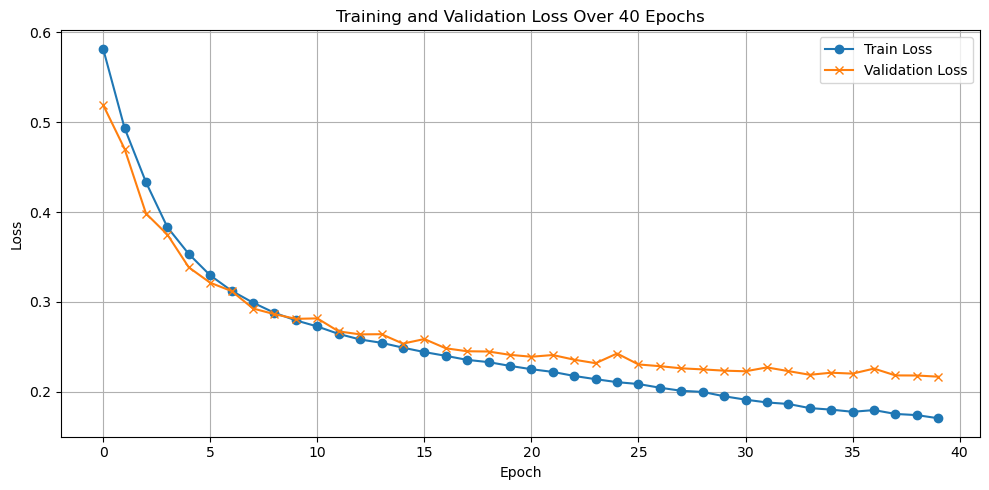

In [19]:
train_losses = [
    0.5818, 0.4936, 0.4332, 0.3831, 0.3533, 0.3295, 0.3123, 0.2991, 0.2878, 0.2794,
    0.2726, 0.2643, 0.2581, 0.2544, 0.2490, 0.2441, 0.2399, 0.2354, 0.2329, 0.2287,
    0.2250, 0.2220, 0.2175, 0.2139, 0.2106, 0.2085, 0.2044, 0.2010, 0.1997, 0.1949,
    0.1911, 0.1880, 0.1863, 0.1817, 0.1800, 0.1776, 0.1795, 0.1752, 0.1739, 0.1704
]

val_losses = [
    0.5193, 0.4704, 0.3984, 0.3749, 0.3384, 0.3213, 0.3120, 0.2926, 0.2863, 0.2811,
    0.2816, 0.2671, 0.2638, 0.2640, 0.2535, 0.2586, 0.2483, 0.2450, 0.2447, 0.2410,
    0.2389, 0.2408, 0.2356, 0.2317, 0.2425, 0.2303, 0.2284, 0.2260, 0.2248, 0.2234,
    0.2227, 0.2270, 0.2229, 0.2188, 0.2211, 0.2201, 0.2257, 0.2181, 0.2180, 0.2167
]


# ======== Plotting Loss Curve After Training ========
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over 40 Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Visulaizing Outputs of the model on the test dataset

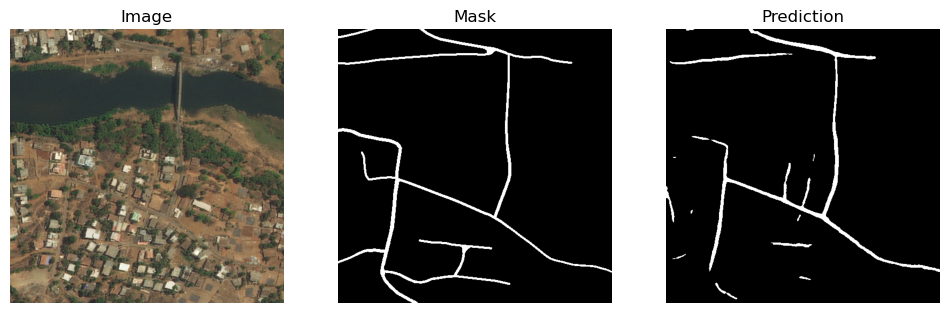

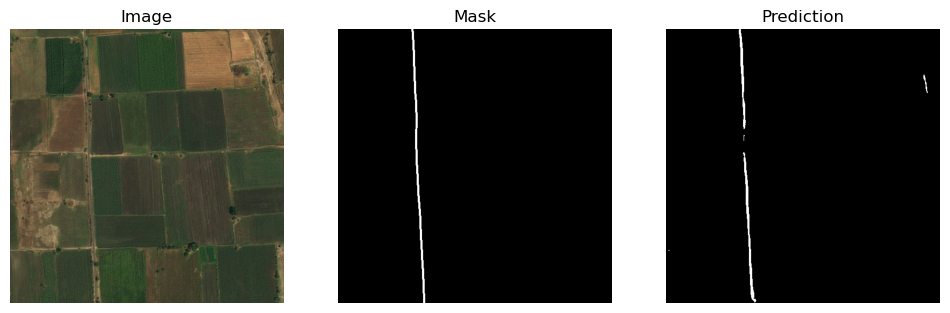

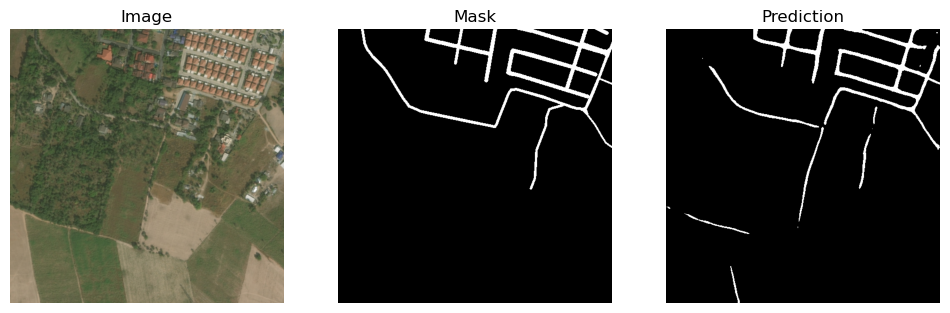

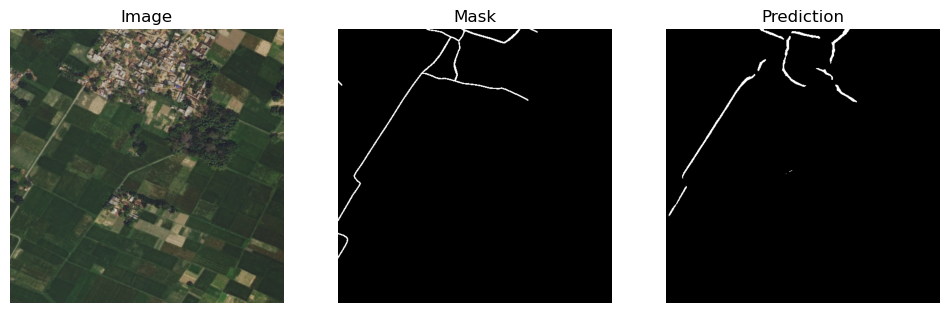

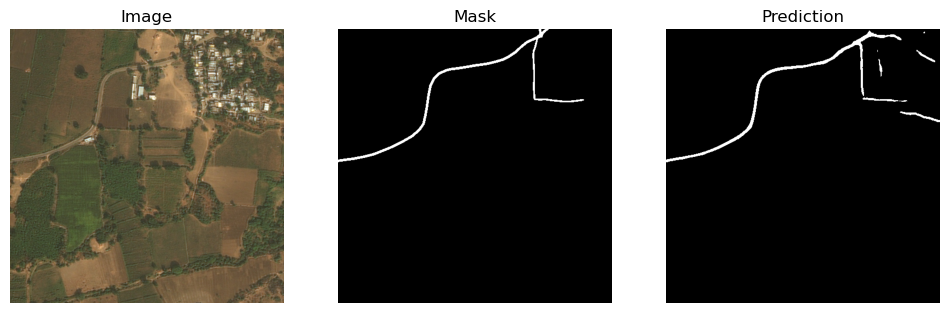

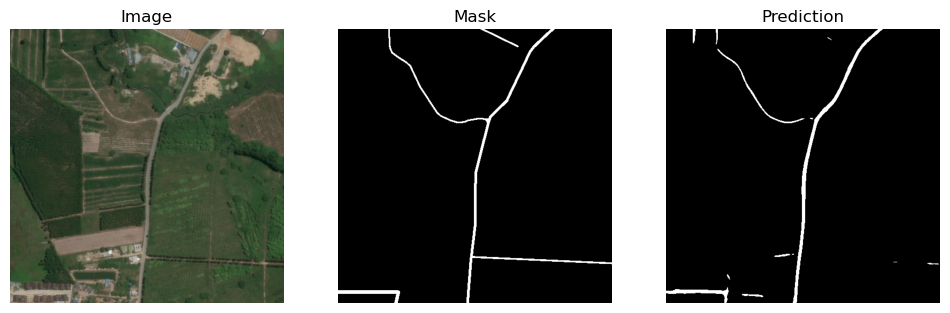

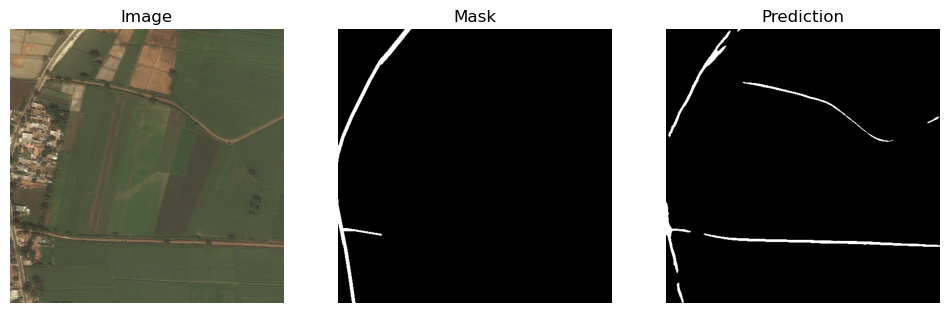

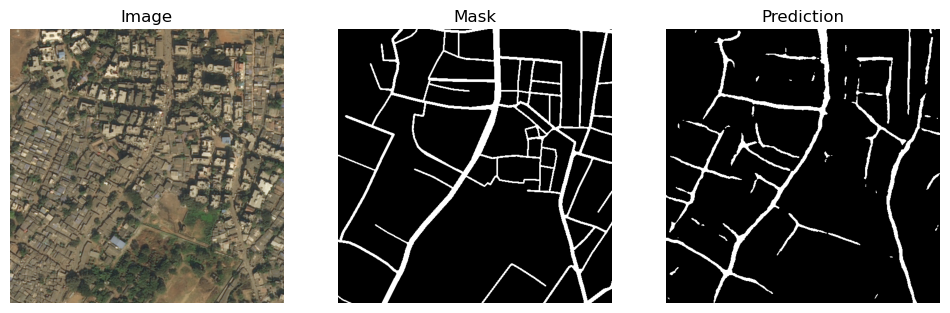

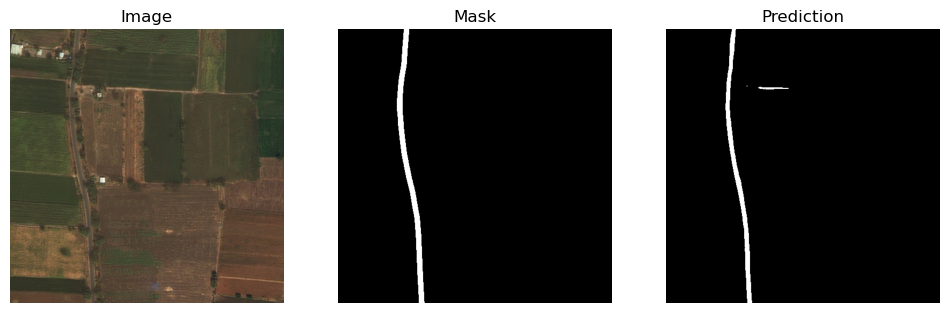

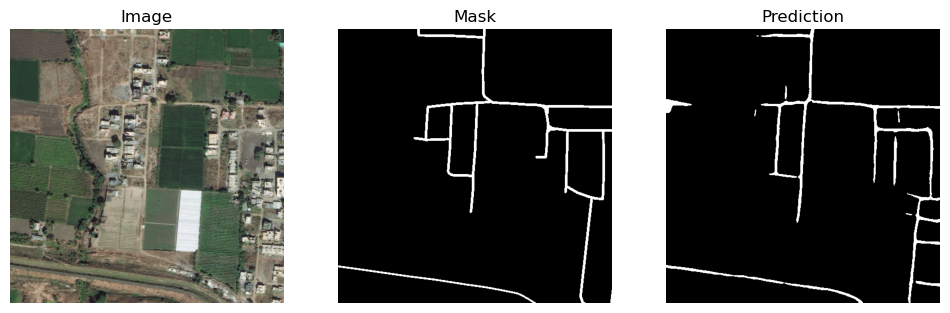

In [33]:
def visualize(model, dataset, num=10):
    model.eval()
    loader = DataLoader(dataset, batch_size=num)
    with torch.no_grad():
        imgs, masks = next(iter(loader))
        preds = model(imgs.to(DEVICE)).cpu()
        for i in range(num):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow((imgs[i].permute(1, 2, 0) * 0.5 + 0.5).numpy())
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].squeeze(), cmap="gray")
            plt.title("Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow((preds[i] > 0.5).squeeze(), cmap="gray")
            plt.title("Prediction")
            plt.axis("off")
            plt.show()

visualize(model, test_ds)


### Test on random image to ensure pipeline consistency

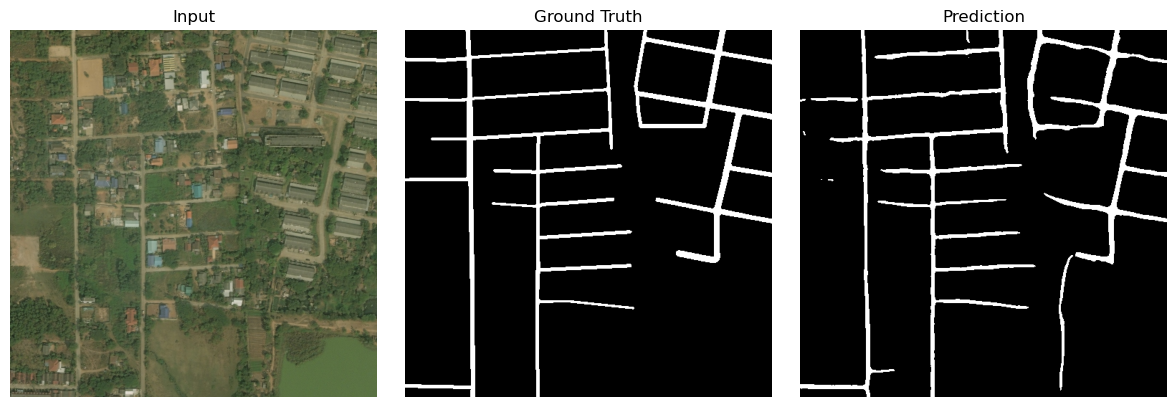

In [25]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# ========== CONFIG ==========
IMG_SIZE = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "best_model_1.pt"
NEW_DATA_DIR = r"D:\new_images"

# ========== Load Model ==========
model = UNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========== Image Transform ==========
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3) 
])

# ========== Load Paths ==========
image_paths = sorted(glob.glob(os.path.join(NEW_DATA_DIR, "*_sat.jpg")))
mask_paths = sorted(glob.glob(os.path.join(NEW_DATA_DIR, "*_mask.png")))
assert len(image_paths) == len(mask_paths), "Mismatch in images and masks"

# ========== Load and Predict ==========
def load_image_and_mask(image_path, mask_path):
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    image_tensor = transform(image).unsqueeze(0).to(DEVICE)
    mask = mask.resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)
    mask_array = np.array(mask) > 127
    return image, image_tensor, mask_array.astype(np.uint8)

# ========== Predict & Visualize ==========
with torch.no_grad():
    for image_path, mask_path in zip(image_paths, mask_paths):
        orig_image, input_tensor, true_mask = load_image_and_mask(image_path, mask_path)
        pred = model(input_tensor)
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

        # Plot
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(orig_image)
        plt.title("Input")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        break 


### Test on new dataset acquired from Washington to ascertain model performance visually

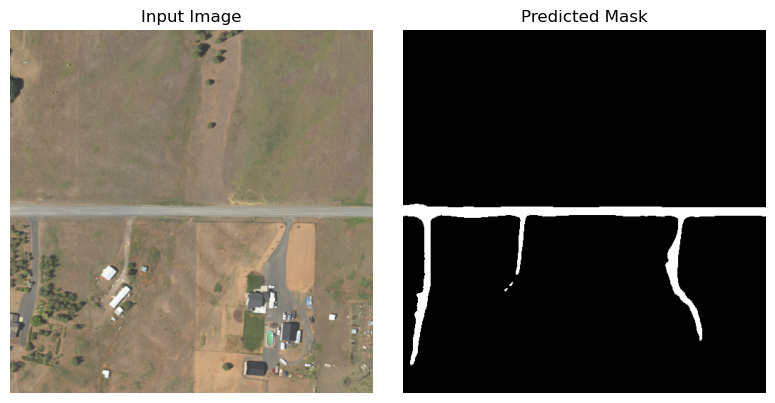

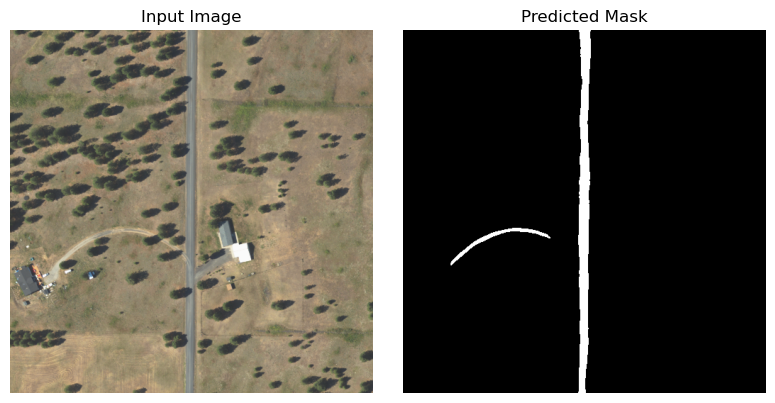

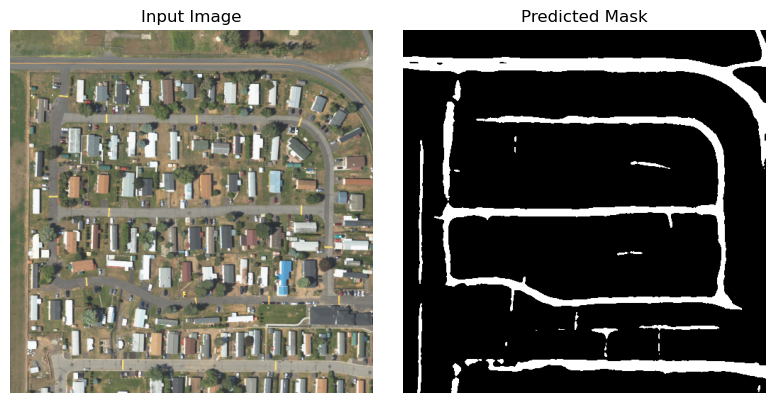

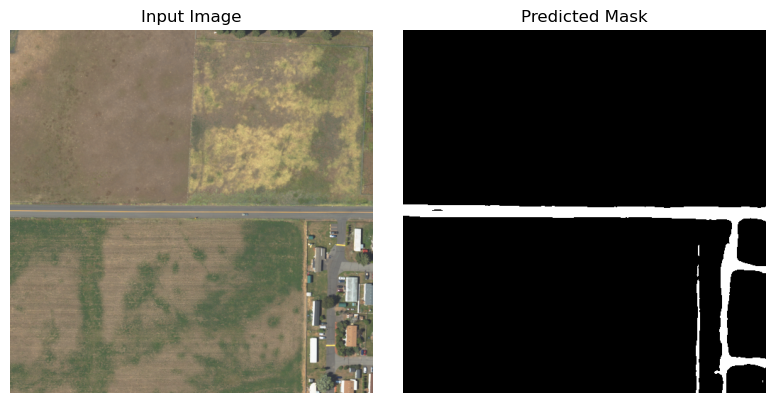

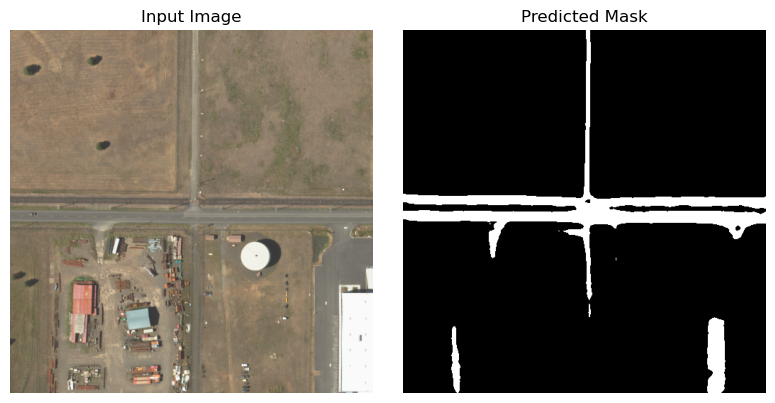

In [13]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import random 

# ========== CONFIG ==========
IMG_SIZE = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "best_model_1.pt"
NEW_DATA_DIR = r"F:\Main Files\road"

# ========== Load Model ==========
model = UNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========== Image Transform ==========
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize to [-1, 1]
])

# ========== Load Image Paths ==========
# ========== Load Image Paths ==========
# Get all files in the directory (assume all are images)
image_paths = sorted(glob.glob(os.path.join(NEW_DATA_DIR, "*")))

# Assert to ensure directory is not empty
assert len(image_paths) > 0, "No images found in the directory."

# Select 5 random image paths
sampled_paths = random.sample(image_paths, min(5, len(image_paths)))

# ========== Predict & Visualize ==========
with torch.no_grad():
    for image_path in sampled_paths:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(DEVICE)

        pred = model(image_tensor)
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

        # Plot
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        # break  
